source link https://neptune.ai/blog/arima-sarima-real-world-time-series-forecasting-guide

# SARIMA 

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime

from itertools import product

from numba import cuda

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

find_best_params = False

#%matplotlib inline

## Monthly views data

In [37]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

data = pd.read_csv('../data/article_statistics_2.csv', parse_dates=[0], index_col=0, date_parser=parser)
data_column_name = "total"

#transform
start_date = datetime(2009,1,1)
end_date = datetime(2021,1,1)
data = data[start_date:end_date]

data = data.asfreq(pd.infer_freq(data.index))

data.head()

,total
date,
2009-01-01,20322
2009-02-01,20613
2009-03-01,22704
2009-04-01,20276
2009-05-01,20669


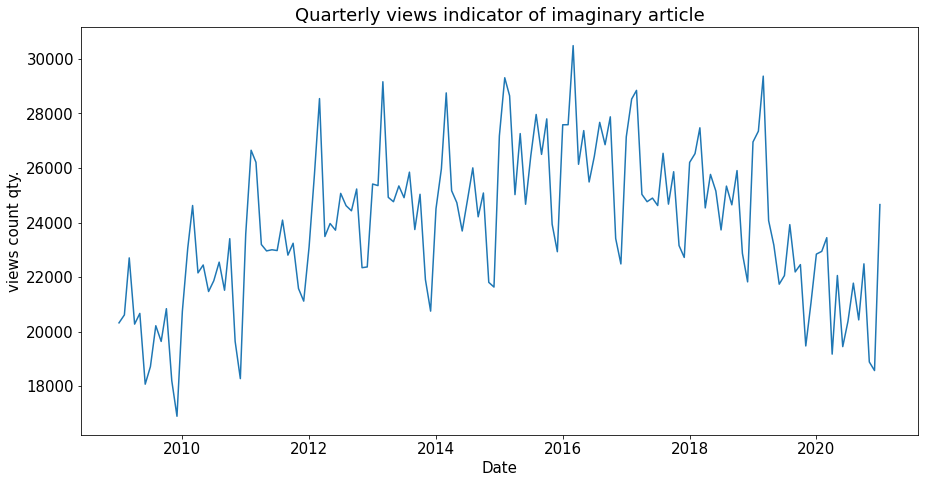

In [38]:
def print_data(data):
    plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
    plt.plot(data)
    plt.title('Monthly views indicator of imaginary article')
    plt.ylabel('views count qty.')
    plt.xlabel('Date')

print_data(data)
#plt.xticks(rotation=90)
#plt.grid(True)
#plt.show()

## STL decomposition

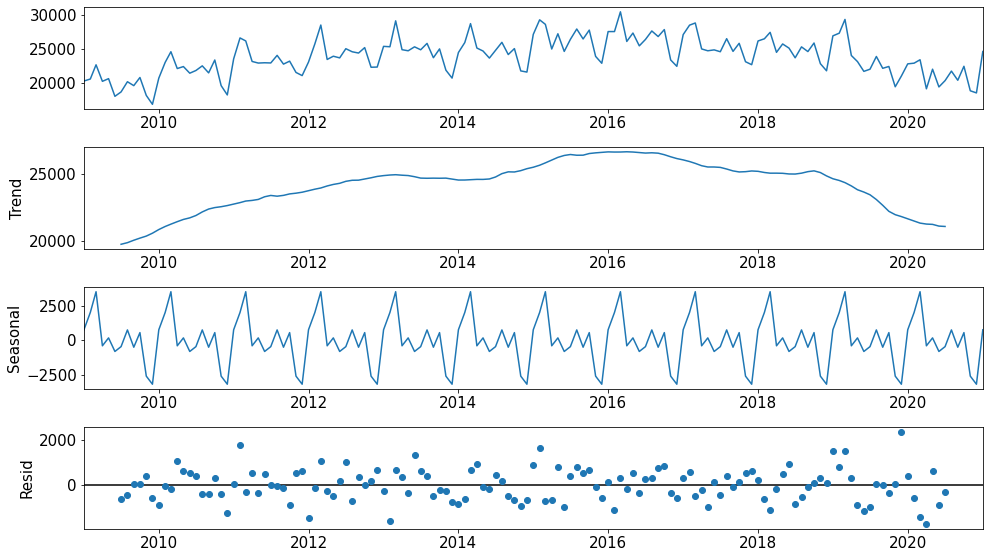

In [39]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(data,model='additive')
fig = result.plot()

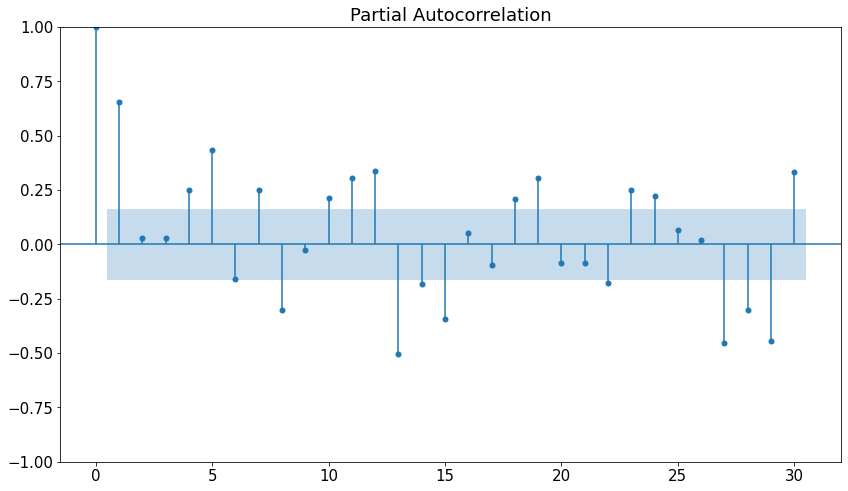

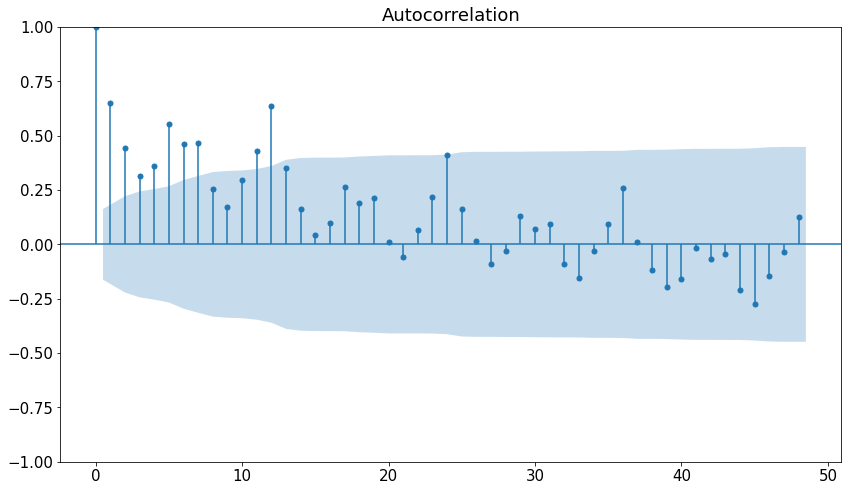

In [40]:
def show_acf_pacf(data):
    pacf_result = plot_pacf(data, lags=30)
    acf_result = plot_acf(data, lags=48)

show_acf_pacf(data[data_column_name])

In [41]:
# Take the log difference to make data stationary
def check_stationarity(ts) -> bool:
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
        print(f'ADF Statistic: {adf}')
        print(f'p-value: {pvalue}')
        return True
    else:
        print('The series is NOT stationary')
        return False

integration_param = 1

while True:
    data[data_column_name] = data[data_column_name].diff()
    data = data.drop(data.index[0])
    #print_data(data)
    if check_stationarity(data[data_column_name]):
        break
    integration_param += 1

print("ARIMA/SARIMA integration param 'd' :", integration_param)
data.head()

The series is NOT stationary
The series is stationary
ADF Statistic: -7.732031085308531
p-value: 1.1187722302047077e-11
ARIMA/SARIMA integration param 'd' : 2


,total
date,
2009-03-01,1800.0
2009-04-01,-4519.0
2009-05-01,2821.0
2009-06-01,-2988.0
2009-07-01,3240.0


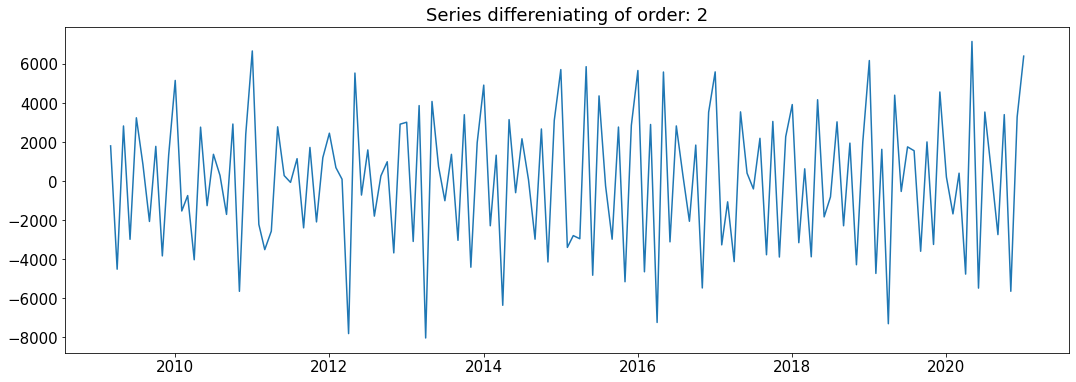

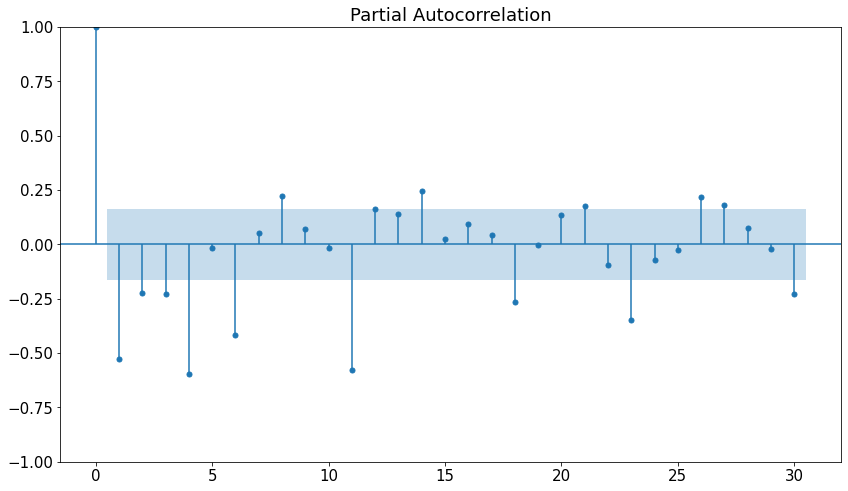

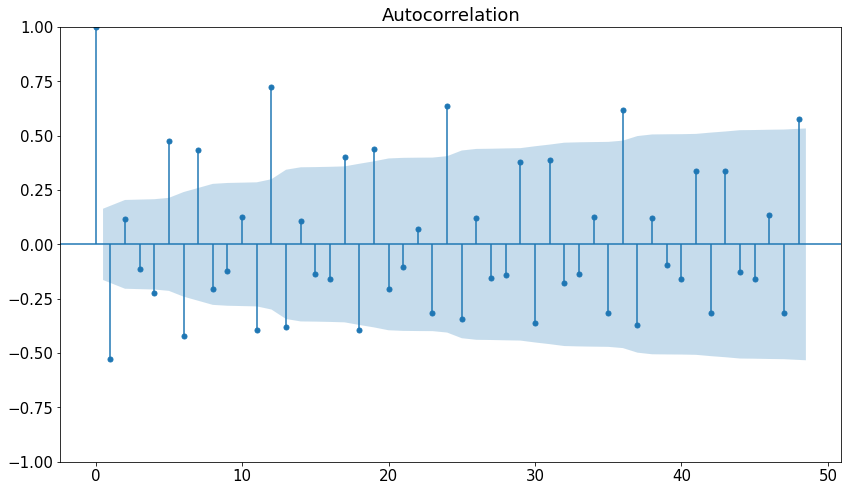

In [42]:
plt.figure(figsize=[18, 6]); # Set dimensions for figure
plt.plot(data[data_column_name])
plt.title("Series difference of order: {0}".format(integration_param))
show_acf_pacf(data[data_column_name])

In [43]:
def optimize_SARIMA(parameters_list, s, data, results):
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])

In [44]:
param_cases = {
    "p": (1, 4, 6, 11),
    "d": range(1, integration_param, 1),
    "q": (1, 5, 7, 12),
    "P": (1, 4, 6, 11),
    "D": range(1, integration_param, 1),
    "Q": (1, 5, 7, 12),
}

p = param_cases["p"]
d = param_cases["d"]
q = param_cases["q"]
P = param_cases["P"]
D = param_cases["D"]
Q = param_cases["Q"]
s = 12 # aka `m` from SARIMA formula

parameters = product(p, d, q, P, D, Q)
parameters_list = list(parameters)
#

## Find best params

In [45]:
if find_best_params:
    result_list = []
    optimize_SARIMA(parameters_list, s, data[data_column_name], result_list)

    result_df = pd.DataFrame(result_list)
    result_df.columns = ['(p,d,q)x(P,D,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    best_params = result_df['(p,d,q)x(P,D,Q)'].iloc[0]

In [64]:
best_p = best_d = best_q = best_P = best_D = best_Q = 1

if find_best_params:
    best_p = best_params[0]
    best_d = best_params[1]
    best_q = best_params[2]
    best_P = best_params[3]
    best_D = best_params[4]
    best_Q = best_params[5]
else:
    best_p = 5
    best_d = 2
    best_q = 5
    best_P = 5
    best_D = 2
    best_Q = 5

model_params = (best_p, best_d, best_q)
model_seasonal_params = (best_P, best_D, best_Q, s)

best_model = SARIMAX(data[data_column_name], order=model_params, seasonal_order=model_seasonal_params).fit(dis=-1)

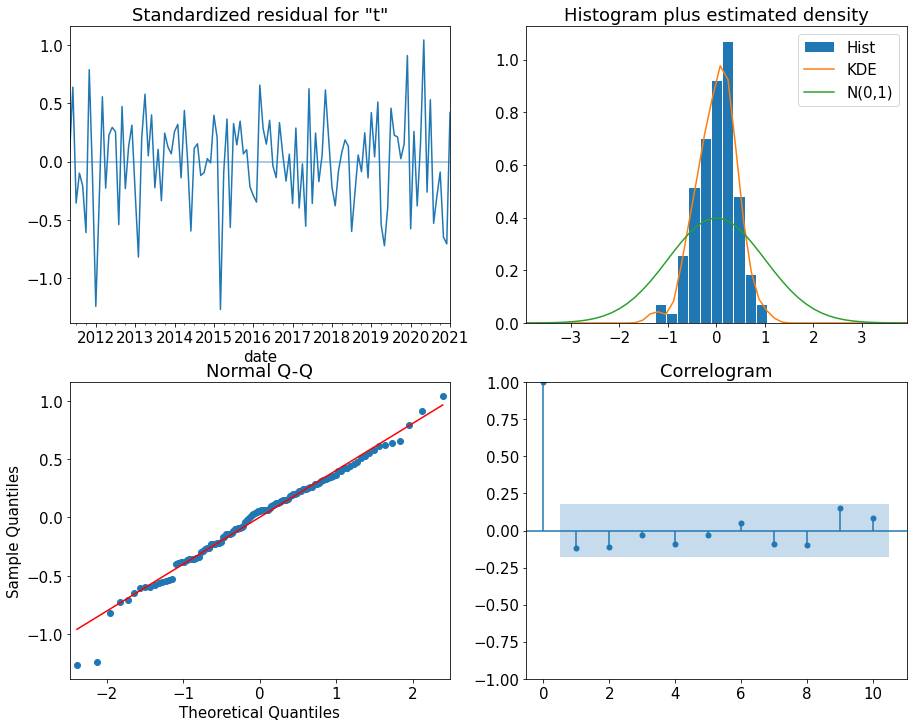

In [49]:
best_model_diag = best_model.plot_diagnostics(figsize=(15,12))

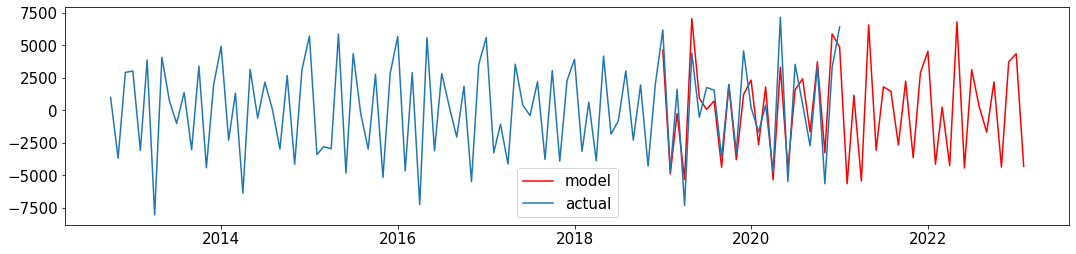

In [70]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 24)
forecast = data['arima_model'].append(forecast)

# cut data
forecast, actual_data = forecast[-50:], data[data_column_name][-100:]

plt.figure(figsize=(18, 4))
plt.plot(forecast, color='r', label='model')
plt.plot(actual_data, label='actual')
plt.legend()
plt.show()